In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import PIL

In [2]:
import scipy
from skimage.measure import label, regionprops
from torchvision.transforms.functional import rotate
from skimage.morphology import binary_closing, binary_dilation, binary_erosion


def mask_orientation_centroid(image: np.ndarray[int]):
    label_img = label(image)
    regions = regionprops((label_img))

    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
    return props.centroid, orientation, props.axis_major_length, props.axis_minor_length


def rotate_image(image_arr: PIL.Image, angle: float | None = None):
    # Convert to numpy array and compute orientation (in radians)

    if angle is not None:
        # If angle is provided explicitly, use that
        return np.array(rotate(image_arr, angle)), angle

    _, orientation, _, _ = mask_orientation_centroid(np.array(image_arr))

    # To make the object horizontal, rotate by the **negative** of its orientation angle
    rotation_angle = -np.rad2deg(orientation) + 90

    print("Orientation (deg):", np.rad2deg(orientation))

    # Rotate and return both the rotated image and the applied angle
    return np.array(rotate(image_arr, rotation_angle)), rotation_angle


def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [3]:
image_data = Path(
    '/Users/tsakalis/ntua/cellforge/data/segmentation_data/pronuclei')

In [4]:
whole_img = PIL.Image.open(
    '/Users/tsakalis/ntua/cellforge/data/segmentation_data/pronuclei/images_pn/348.jpg'
)

In [5]:
sample_id = 'D2016.01.23_S1202_I149_7'
base_pth = Path('/Users/tsakalis/downloads')

masks_pth = base_pth / f'{sample_id}.npy'

timelapse_pth = base_pth / f'{sample_id}_images'

all_image_paths = sorted(list(timelapse_pth.glob('*')),
                         key=lambda x: int(x.stem.split('_')[0]))[:200]

all_masks = np.load(masks_pth)

In [6]:
len(all_image_paths)

146

In [263]:
frame_idx = 38

In [264]:
import PIL

from PIL import Image
# for img_pth in (image_data / 'masks_pn').glob('*'):
whole_img = PIL.Image.open(all_image_paths[frame_idx])

img = PIL.Image.fromarray(
    (binary_closing(all_masks[frame_idx])).astype(np.uint8))

rotated_image, rotation_angle = rotate_image(img)
centroid, _, major_axis_length, minor_axis_length = mask_orientation_centroid(
    rotated_image == 1)

y0, x0 = centroid

rotated_image_orig, _ = rotate_image(Image.fromarray((np.array(whole_img))),
                                     rotation_angle)
# img.show()

rotated_image_whole = rotate_image(whole_img, rotation_angle)
# img.show()
# break

Orientation (deg): 86.15056016798589


In [265]:
major_axis_length / minor_axis_length

1.1988793790285708

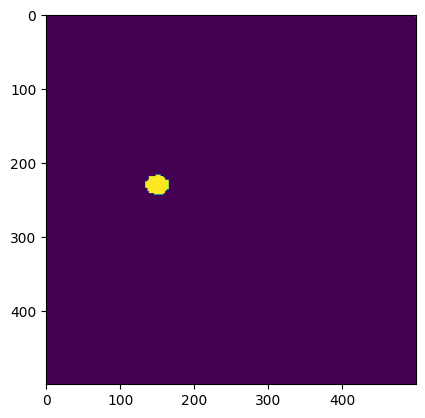

In [266]:
plt.imshow(all_masks[frame_idx])

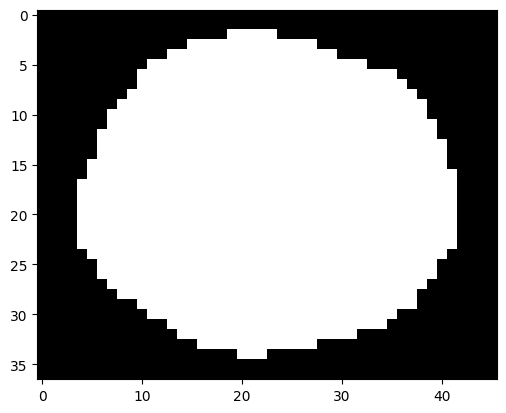

In [249]:
y0, x0 = centroid
a1 = int(x0 - major_axis_length * 0.6)
b1 = int(x0 + major_axis_length * 0.65)

a2 = int(y0 - minor_axis_length * 0.6)
b2 = int(y0 + minor_axis_length * 0.65)
import cv2

from PIL import Image

width, height = np.array(rotated_image)[a2:b2, a1:b1].shape

isolated_pn = np.array(rotated_image_orig)[a2:b2, a1:b1]

# upscaled_img = cv2.resize(rotated_image[a2:b2, a1:b1],
#                           None,
#                           fx=15,
#                           fy=15,
#                           interpolation=cv2.INTER_CUBIC)

# im = Image.fromarray(upscaled_img).resize((width, height),
#                                           resample=Image.LANCZOS)
smoothed_img = cv2.GaussianBlur(
    binary_dilation(rotated_image)[a2:b2, a1:b1].astype(np.uint8), (19, 19), 0)

plt.imshow(smoothed_img, cmap='gray')
plt.show()

# plt.imshow(rotated_image[a2:b2, a1:b1] > 10, cmap='gray')
# plt.show()

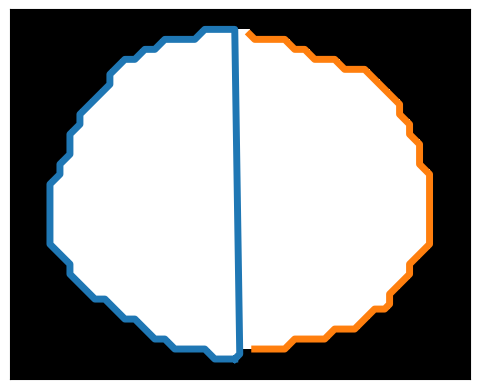

In [250]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

# Construct some test data
# x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
# r = np.sin(np.exp(np.sin(x)**3 + np.cos(y)**2))

# Find contours at a constant value of 0.8
contours = measure.find_contours(smoothed_img, None)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(smoothed_img, cmap=plt.cm.gray)

for contour in contours:
    half_contour = contour[contour[:, 1] > smoothed_img.shape[1] // 2]

    half_contour1 = contour[contour[:, 1] < smoothed_img.shape[1] // 2]
    ax.plot(half_contour1[:, 1], half_contour1[:, 0], linewidth=5)
    ax.plot(half_contour[:, 1], half_contour[:, 0], linewidth=5)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [251]:
import numpy as np
import matplotlib.pyplot as plt


def fit_ellipse(x, y):
    A = np.stack([x**2, x * y, y**2, x, y]).T
    b = np.ones_like(x)

    return np.linalg.lstsq(A, b)[0].squeeze()


Fitted circle: center=(26.234, -18.176), radius=15.146


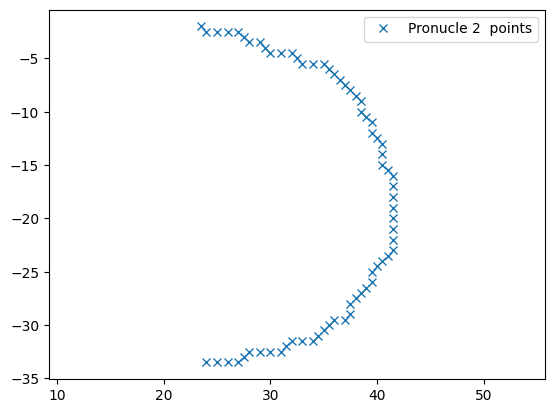

In [252]:
import numpy as np
import matplotlib.pyplot as plt


def fit_circle(x, y):
    """
    Fit a circle to the given x, y points using least squares.
    Returns the circle parameters: x0, y0 (center), and r (radius).
    """
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    """
    Return npts points on the circle defined by (x0, y0, r).
    """
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # Example noisy circle
    np.random.seed(42)

    theta = np.linspace(0, 2 * np.pi, 100)
    x = half_contour[:, 1]
    y = -half_contour[:, 0]

    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")

    xf, yf = get_circle_pts(x0, y0, r)

    # plt.plot(x, y, 'x', label='Pronucle 1  points')
    # plt.plot(xf, yf, '-', label='Fitted circle 1')
    plt.axis('equal')

    # x = half_contour1[:, 1]
    # y = -half_contour1[:, 0]

    # x0, y0, r = fit_circle(x, y)
    # print(f"Fitted circle: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")

    # xf, yf = get_circle_pts(x0, y0, r)

    plt.plot(x, y, 'x', label='Pronucle 2  points')
    # plt.plot(xf, yf, '-', label='Fitted circle 2')
    plt.axis('equal')
    plt.legend()
    plt.show()


Fitted circle 1: center=(26.234, -18.176), radius=15.146
Fitted circle 2: center=(20.037, -17.992), radius=15.950


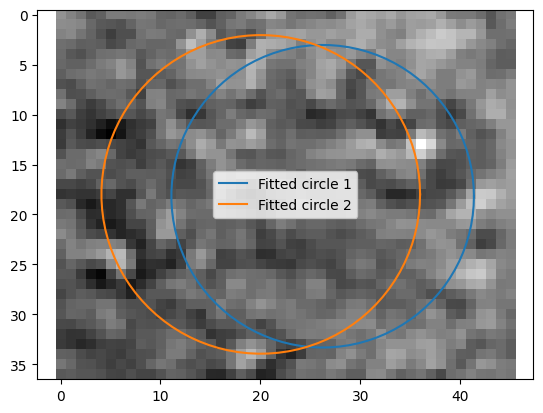

In [253]:
import numpy as np
import matplotlib.pyplot as plt

X0, Y0 = centroid


def fit_circle(x, y):
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # assume you already have isolated_pn, half_contour, and peakind defined
    fig, ax = plt.subplots()
    ax.imshow(isolated_pn, cmap='gray')  # show the image

    # First PN
    x = half_contour[:, 1]
    y = -half_contour[:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 1: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0, -y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 1 points')
    ax.plot(xf, yf, '-', label='Fitted circle 1')

    # Second PN
    x = half_contour1[:, 1]
    y = -half_contour1[:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 2: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0, -y0, r)
    # ax.plot(x, y, 'x', label='Pronucle 2 points')
    ax.plot(xf, yf, '-', label='Fitted circle 2')
    # ax.plot(half_contour[:, 1], half_contour[:, 0], linewidth=5)

    ax.axis('equal')
    ax.legend()
    plt.show()


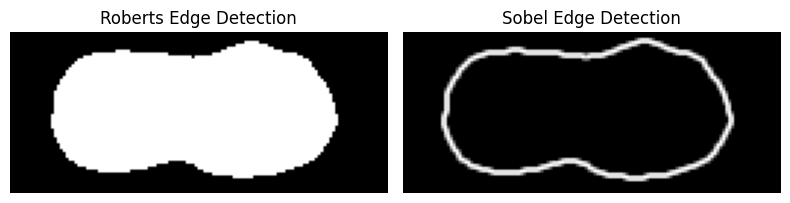

In [236]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images

# smoothed_img = cv2.GaussianBlur(isolated_pn, (5, 5), 0)

image = smoothed_img
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

axes[0].imshow(smoothed_img, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

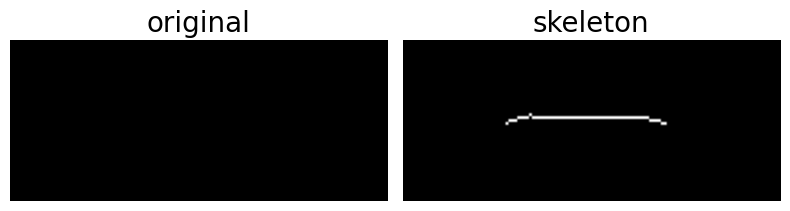

In [235]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

# Invert the horse image
image = invert(data.horse())

# perform skeletonization
skeleton = skeletonize(smoothed_img)

# display results
fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(8, 4),
                         sharex=True,
                         sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

In [189]:
def inverse_rotate_point(x, y, angle_deg, center):
    """
    Rotate a point (or arrays of points) (x, y) by angle_deg (in degrees)
    around a given center (cx, cy).
    """
    rad = np.deg2rad(angle_deg)
    cx, cy = center
    x_shifted = x - cx
    y_shifted = y - cy
    x_new = cx + np.cos(rad) * x_shifted - np.sin(rad) * y_shifted
    y_new = cy + np.sin(rad) * x_shifted + np.cos(rad) * y_shifted
    return x_new, y_new


Fitted circle 1: center=(84.746, -26.801), radius=24.371
Fitted circle 2: center=(39.378, -26.581), radius=24.090


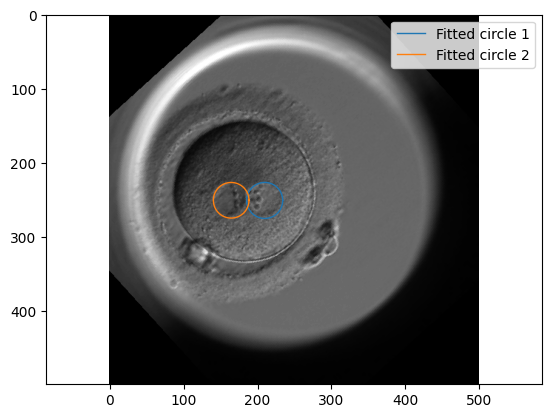

In [196]:
import numpy as np
import matplotlib.pyplot as plt

X0, Y0 = centroid


def fit_circle(x, y):
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    x0, y0 = c[0], c[1]
    r = np.sqrt(c[2] + x0**2 + y0**2)
    return x0, y0, r


def get_circle_pts(x0, y0, r, npts=100, tmin=0, tmax=2 * np.pi):
    t = np.linspace(tmin, tmax, npts)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    return x, y


if __name__ == '__main__':
    # assume you already have isolated_pn, half_contour, and peakind defined
    fig, ax = plt.subplots()
    ax.imshow(np.array(rotated_image_orig), cmap='gray')  # show the image

    # First PN
    x = half_contour[:, 1]
    y = -half_contour[:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 1: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0 + a1, -y0 + a2, r)
    # ax.plot(x, y, 'x', label='Pronucle 1 points')
    ax.plot(xf, yf, '-', label='Fitted circle 1', linewidth=1)

    # Second PN
    x = half_contour1[:, 1]
    y = -half_contour1[:, 0]
    x0, y0, r = fit_circle(x, y)
    print(f"Fitted circle 2: center=({x0:.3f}, {y0:.3f}), radius={r:.3f}")
    xf, yf = get_circle_pts(x0 + a1, -y0 + a2, r)
    # ax.plot(x, y, 'x', label='Pronucle 2 points')
    ax.plot(xf, yf, '-', label='Fitted circle 2', linewidth=1)
    # ax.plot(half_contour[:, 1], half_contour[:, 0], linewidth=5)

    ax.axis('equal')
    ax.legend()
    plt.show()


In [268]:
area = np.sum(all_masks, axis=(1, 2))

# find the frames the pn are showing
max_start, max_len = find_signal(area > 10)

visible_pn

(array([ 4.,  2.,  1.,  3.,  6.,  2., 13., 10., 32., 24.]),
 array([ 660. ,  974.6, 1289.2, 1603.8, 1918.4, 2233. , 2547.6, 2862.2,
        3176.8, 3491.4, 3806. ]),
 <BarContainer object of 10 artists>)

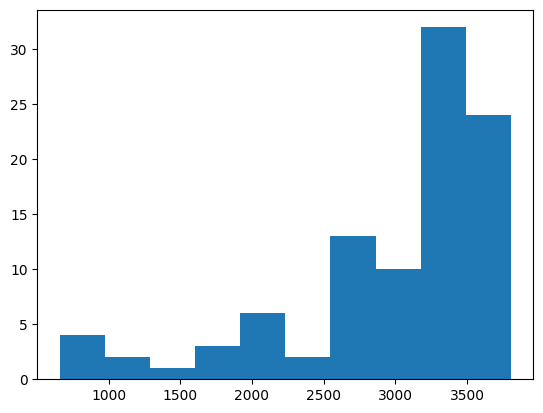

In [280]:
plt.hist(area[max_start:max_start + max_len])

In [341]:
def sample_frames(area: np.ndarray[np.uint64],
                  n_samples: int = 10) -> np.ndarray[np.int64]:

    max_start, max_len = find_signal(area > 10)

    q_90 = np.quantile(area[max_start:max_start + max_len], 0.8)

    q_10 = np.quantile(area[max_start:max_start + max_len], 0.1)

    low_samples = max_start + np.argwhere(area[max_start:max_start +
                                               max_len] < q_10)
    high_samples = max_start + np.argwhere(area[max_start:max_start +
                                                max_len] > q_90)

    return np.random.choice(
        np.vstack([low_samples, high_samples]).flatten(), n_samples)

In [343]:
sample_frames(area)

array([110,  93, 114, 111, 117,  39,  41, 110,  45, 112])

In [342]:
np.argwhere(area[max_start:max_start + max_len] > q_90)

array([[55],
       [56],
       [58],
       [59],
       [64],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],
       [77],
       [78],
       [80],
       [83],
       [85],
       [86],
       [92],
       [94]])

In [308]:
max_start + 55

92

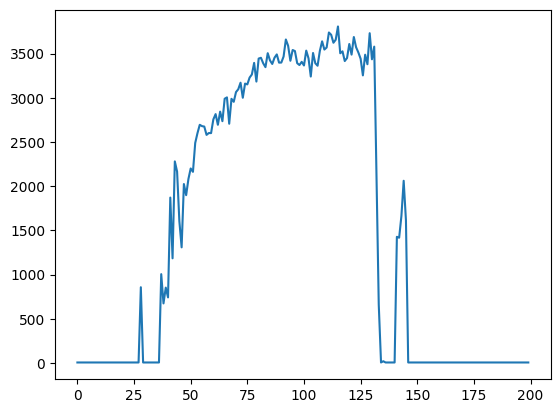

In [301]:
plt.plot(area)

In [302]:
max_start

37

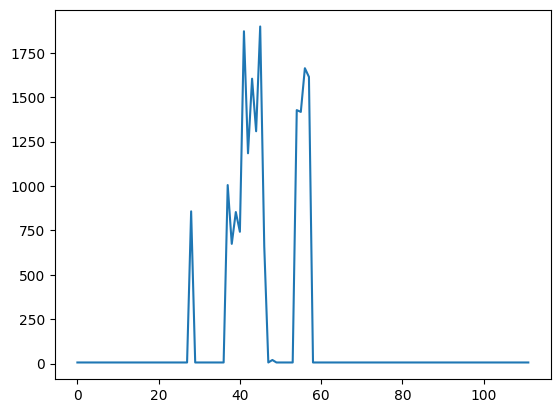

In [303]:
plt.plot(area[area < q_20])

In [304]:
max_start

37

In [192]:
b1

254

/var/folders/gb/2dm73f1s22n8755ydqgrblxw0000gn/T/ipykernel_88509/3967317513.py:21: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask = vectorized.contains(poly, X, Y)


Circle center: (np.float64(86.33967935871743), np.float64(-26.706412825651302))
Circle radius: 21.24955133644002


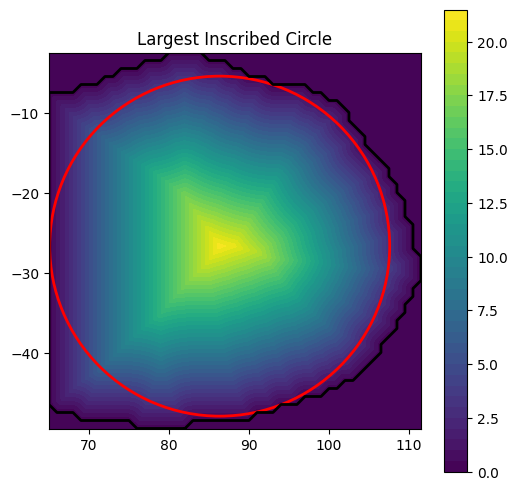

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import vectorized
from scipy.ndimage import distance_transform_edt


def largest_inscribed_circle(x, y, grid_size=500):
    # Create a polygon from the curve (assumes curve is oriented so that the interior is on the right)
    poly = Polygon(zip(x, y))

    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = poly.bounds

    # Create a grid over the bounding box
    xs = np.linspace(minx, maxx, grid_size)
    ys = np.linspace(miny, maxy, grid_size)
    X, Y = np.meshgrid(xs, ys)

    # Create a mask of points inside the polygon
    mask = vectorized.contains(poly, X, Y)

    # Convert mask to uint8 (True=1, False=0)
    mask_int = mask.astype(np.uint8)

    # Compute the distance transform; each point gets the distance to the nearest zero (outside) pixel
    # The sampling parameter adjusts for the grid spacing in each dimension.
    dx = (maxx - minx) / grid_size
    dy = (maxy - miny) / grid_size
    dt = distance_transform_edt(mask_int, sampling=(dy, dx))

    # Find the index of the maximum distance (largest inscribed circle)
    max_idx = np.unravel_index(np.argmax(dt), dt.shape)
    max_radius = dt[max_idx]

    # Convert grid index to real coordinates (note: X corresponds to columns, Y to rows)
    center_x = xs[max_idx[1]]
    center_y = ys[max_idx[0]]
    circle_center = (center_x, center_y)

    return circle_center, max_radius, poly, X, Y, dt


# Example usage:
if __name__ == '__main__':
    # Example curve: a rectangle defined in clockwise order
    # x = [0, 1, 1, 0]
    # y = [0, 0, 1, 1]

    center, radius, poly, X, Y, dt = largest_inscribed_circle(x, y)
    print("Circle center:", center)
    print("Circle radius:", radius)

    # Plotting the result
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the distance transform as a contour plot
    contour = ax.contourf(X, Y, dt, levels=50, cmap='viridis')
    plt.colorbar(contour, ax=ax)

    # Draw the largest inscribed circle
    circle = plt.Circle(center, radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)

    # Plot the polygon boundary
    x_poly, y_poly = poly.exterior.xy
    ax.plot(x_poly, y_poly, color='black', linewidth=2)

    ax.set_aspect('equal')
    plt.title("Largest Inscribed Circle")
    plt.show()
